# Design Flowsheet for NGCC + SOEC with Steam Integration

This flowsheet example provides a design point model for integration of an SOEC for hydrogen production with an NGCC.  The NGCC nominally produces 650 MW net, and includeds 97% CO2 capture.  The SOEC unit model used here is only approriate for design point calculations.  Simulations of off-desing cases require it to be replaced by a more detailed model.  The SOEC desing point model is based on water utilization and basic mass and energy balances.  The numebr of cells is etimated from a given cell sized and a current density estimate provided by the user. 

This flowsheet can be used to determine design point performance, and to optimize the flowsheet design.  

## Import Required Modules

In [1]:
import os
import math
import numpy as np
import pytest
from IPython.core.display import SVG
import pyomo.environ as pyo
from idaes.core.solvers import use_idaes_solver_configuration_defaults
import idaes
import idaes.core.util.scaling as iscale
import idaes.core.util as iutil
import soec_flowsheet_costing
import ngcc_soec

    idaes.models_extra.power_generation.properties  (deprecated in
    2.0.0.alpha0) (called from <frozen importlib._bootstrap>:228)
    idaes.models_extra.power_generation.properties.natural_gas_PR (deprecated
    in 2.0.0.alpha0) (called from <frozen importlib._bootstrap>:228)
    to idaes.models_extra.power_generation.unit_models  (deprecated in
    2.0.0.alpha0) (called from <frozen importlib._bootstrap>:228)
    moved to idaes.models_extra.power_generation.unit_models.helm (deprecated
    in 2.0.0.alpha0) (called from <frozen importlib._bootstrap>:228)


## Make Output Directories

This notebook can produce a large number of output files.  To make it easier to manage, some subdirectories are used to orginize output.  This enesures that the drectories exist.

In [2]:
def make_directory(path):
    """Make a directory if it doesn't exist"""
    try:
        os.mkdir(path)
    except FileExistsError:
        pass
    
make_directory("data")
make_directory("data_pfds")
make_directory("data_tabulated")

## Set Global Solver Options

Setting global solver options applies them to any solver created subsequently, including the ones used for initialization.  The used scaling option disables Ipopt's automatic scaling and allows it to uses provided variable scaling.

In [3]:
use_idaes_solver_configuration_defaults()
idaes.cfg.ipopt.options.nlp_scaling_method = "user-scaling"
solver = pyo.SolverFactory("ipopt")

## Create and Initialize the NGCC + SOEC Model

In [4]:
m = pyo.ConcreteModel()
m.fs = ngcc_soec.NgccSoecFlowsheet(default={"dynamic":False})
iscale.calculate_scaling_factors(m)
m.fs.initialize(
    load_from="ngcc_soec_init.json.gz",
    save_to="ngcc_soec_init.json.gz"
)
res = solver.solve(m, tee=True)
soec_flowsheet_costing.get_solo_soec_capital_costing(m.fs.soec)
res = solver.solve(m, tee=True)

2022-03-31 15:04:39 [WARNING] idaes.core.base.unit_model: DEPRECATION: <class 'idaes.core.base.process_block._ScalarSolidOxideCell'> has overloaded the initialize method. In v2.0, IDAES Will be moving to having a centralized initialize method which calls unit-specific initialize_build methods instead. Model developers should update their models to implement the initialize_build method instead of overloading initialize.
2022-03-31 15:04:39 [WARNING] idaes.core.base.unit_model: DEPRECATION: <class 'idaes.core.base.process_block._ScalarSocChannel'> has overloaded the initialize method. In v2.0, IDAES Will be moving to having a centralized initialize method which calls unit-specific initialize_build methods instead. Model developers should update their models to implement the initialize_build method instead of overloading initialize.
2022-03-31 15:04:39 [WARNING] idaes.core.base.unit_model: DEPRECATION: <class 'idaes.core.base.process_block._ScalarSocContactResistor'> has overloaded the in



Gas Trubine Section



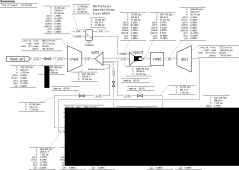



HRSG Section



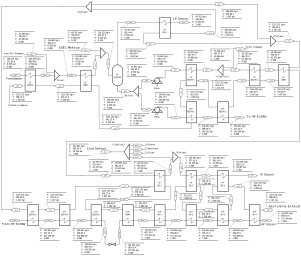



Steam Turbine Section



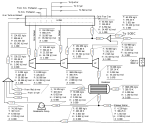



SOEC Section



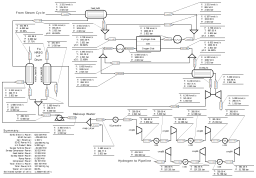

In [5]:
def display_pfd():
    print("\n\nGas Trubine Section\n")
    display(SVG(m.fs.ngcc.gt.write_pfd()))
    print("\n\nHRSG Section\n")
    display(SVG(m.fs.ngcc.hrsg.write_pfd()))
    print("\n\nSteam Turbine Section\n")
    display(SVG(m.fs.ngcc.st.write_pfd()))
    print("\n\nSOEC Section\n")
    display(SVG(m.fs.soec.write_pfd()))

m.fs.ngcc.gt.write_pfd(fname="data_pfds/gt_soec_base.svg")
m.fs.ngcc.hrsg.write_pfd(fname="data_pfds/hrsg_soec_base.svg")
m.fs.ngcc.st.write_pfd(fname="data_pfds/st_soec_base.svg")
m.fs.soec.write_pfd(fname="data_pfds/soec_soec_base.svg")

display_pfd()

In [6]:
m.fs.ngcc.net_power_mw.display()
m.fs.ngcc.st.steam_turbine.throttle_valve[1].deltaP.display()

net_power_mw : Size=1, Index=fs._time, Units=MW
    Key : Lower : Value            : Upper : Fixed : Stale : Domain
    0.0 :  None : 622.586290743058 :  None : False : False :  Reals
deltaP : Size=1, Index=fs._time, ReferenceTo=fs.ngcc.st.steam_turbine.throttle_valve[1].control_volume.deltaP
    Key : Lower : Value              : Upper : Fixed : Stale : Domain
    0.0 :  None : -3565327.899512856 :  None : False : False :  Reals


In [7]:
decision_vars = []
def make_decision_var(v, lb, ub):
    v.unfix()
    v.setlb(lb)
    v.setub(ub)
    decision_vars.append(v)

# Add constraints for optimization
m.fs.ngcc.st.steam_turbine.throttle_valve[1].deltaP.setub(-1e5)
m.fs.soec.sweep_recycle_split.mixed_state[0].mole_frac_comp["O2"].setub(0.4)
m.fs.soec.sweep_recycle_split.mixed_state[0].temperature.setub(1030)
m.fs.soec.feed_recycle_split.mixed_state[0].temperature.setub(1030)

@m.fs.Constraint(m.fs.time)
def makeup_water_constraint(b, t):
    return m.fs.soec.water_pump.inlet.flow_mol[t] == m.fs.soec.feed_hx01.tube_inlet.flow_mol[t]

@m.fs.Constraint(m.fs.time)
def delta_T_h_constraint(b, t):
    return (
        m.fs.soec.feed_heater.control_volume.properties_out[t].temperature -
        m.fs.soec.feed_recycle_split.mixed_state[t].temperature
    )**2 <= 1600

@m.fs.Constraint(m.fs.time)
def delta_T_o_constraint(b, t):
    return (
        m.fs.soec.sweep_heater.control_volume.properties_out[t].temperature -
        m.fs.soec.sweep_recycle_split.mixed_state[t].temperature
    )**2 <= 1600

@m.fs.Constraint(m.fs.time)
def delta_T_1_constraint(b, t):
    return (
        m.fs.soec.sweep_heater.control_volume.properties_out[t].temperature -
        m.fs.soec.feed_recycle_split.mixed_state[t].temperature
    )**2 <= 1600

@m.fs.Constraint(m.fs.time)
def delta_T_2_constraint(b, t):
    return (
        m.fs.soec.feed_heater.control_volume.properties_out[t].temperature -
        m.fs.soec.sweep_recycle_split.mixed_state[t].temperature
    )**2 <= 1600

m.fs.soec.water_pump.inlet.flow_mol.unfix()
make_decision_var(m.fs.soec.sweep_recycle_split.split_fraction[0, "out"], 0.50, 0.97)
make_decision_var(m.fs.soec.feed_recycle_split.split_fraction[0, "out"], 0.50, 0.98) 
make_decision_var(m.fs.soec.water_split.split_fraction[0, "outlet1"], 0.3, 0.7)
make_decision_var(m.fs.soec.sweep_compressor.inlet.flow_mol[0], 100, 8000)
make_decision_var(m.fs.soec.soec.potential[0], 1.28, 1.38)
make_decision_var(m.fs.soec.feed_heater.control_volume.properties_out[0].temperature, 900, 1020)
make_decision_var(m.fs.soec.sweep_heater.control_volume.properties_out[0].temperature, 900, 1020)

m.fs.obj = pyo.Objective(expr=(m.fs.ngcc.net_power[0] + m.fs.soec.total_electric_power[0])/1e6)

In [8]:
res = solver.solve(m, tee=True)

Ipopt 3.13.2: nlp_scaling_method=user-scaling
tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale s



Gas Trubine Section



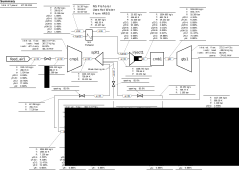



HRSG Section



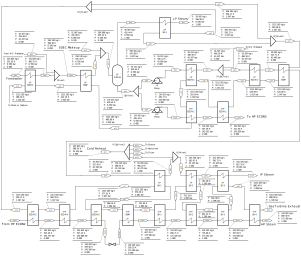



Steam Turbine Section



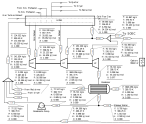



SOEC Section



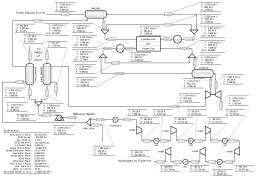

In [9]:
display_pfd()

In [10]:
print(f"Overall net power: {-pyo.value(m.fs.obj)} MW")
for v in decision_vars:
    print(f"{v} {pyo.value(v)}")

Overall net power: -47.08130025470495 MW
fs.soec.sweep_recycle_split.split_fraction[0.0,out] 0.97
fs.soec.feed_recycle_split.split_fraction[0.0,out] 0.5831216558230263
fs.soec.water_split.split_fraction[0.0,outlet1] 0.5006117750488656
fs.soec.sweep_compressor.control_volume.properties_in[0.0].flow_mol 3863.366975294216
fs.soec.soec.potential[0.0] 1.31194566208564
fs.soec.feed_heater.control_volume.properties_out[0.0].temperature 990.0000098850627
fs.soec.sweep_heater.control_volume.properties_out[0.0].temperature 990.0000152554277


In [11]:
import pandas as pd
gt_powers = np.linspace(480., 300., int((480. - 300.)/10.) + 1).tolist()
hp_powers = np.linspace(5, 1.5, int((5. - 1.5)/0.5) + 1).tolist()

m.fs.ngcc.cap_specific_reboiler_duty.fix(2.4e6)
m.fs.ngcc.cap_fraction.fix(0.97)

df = pd.DataFrame(columns=m.fs.tags_output.table_heading())
i = 1
for gp in gt_powers:
    gpstr = str(math.ceil(gp))
    m.fs.ngcc.gt.gt_power.fix(-gp*1e6)
    save_to_last = f"data/ngcc_soec_{gpstr}_5000.json.gz"
    for hp in hp_powers:
        m.fs.soec.hydrogen_product_rate.fix(hp)
        hpstr = str(math.ceil(hp*1000))
        save_to = f"data/ngcc_soec_{gpstr}_{hpstr}.json.gz"
        print(save_to)
        if os.path.exists(save_to):
            iutil.from_json(m, fname=save_to, wts=iutil.StoreSpec(suffix=False))
        else:
            res = solver.solve(m, tee=True)
            if not pyo.check_optimal_termination(res):
                break
            iutil.to_json(m, fname=save_to)
        print(f"Overall net power: {-pyo.value(m.fs.obj)} MW")
        for v in decision_vars:
            print(f"{v} {pyo.value(v)}")
        m.fs.soec.water_pump.inlet.flow_mol.display()
        df.loc[i] = m.fs.tags_output.table_row(numeric=True)
        i += 1
    # go to the closes part of the start of the next series.
    iutil.from_json(m, fname=save_to_last, wts=iutil.StoreSpec(suffix=False))

data/ngcc_soec_480_5000.json.gz
Overall net power: -43.504766099762556 MW
fs.soec.sweep_recycle_split.split_fraction[0.0,out] 0.97
fs.soec.feed_recycle_split.split_fraction[0.0,out] 0.5832459836325837
fs.soec.water_split.split_fraction[0.0,outlet1] 0.5006430870301124
fs.soec.sweep_compressor.control_volume.properties_in[0.0].flow_mol 3863.3669753008667
fs.soec.soec.potential[0.0] 1.3119447301556766
fs.soec.feed_heater.control_volume.properties_out[0.0].temperature 990.0000098857706
fs.soec.sweep_heater.control_volume.properties_out[0.0].temperature 990.0000152432467
_flow_mol_inlet_ref : Size=1, Index=fs._time, ReferenceTo=fs.soec.water_pump.control_volume.properties_in[:].component('flow_mol').parent_block()
    Key : Lower : Value            : Upper : Fixed : Stale : Domain
    0.0 :  None : 2879.38235742177 :  None : False : False :  Reals
data/ngcc_soec_480_4500.json.gz
Overall net power: 28.97132248732674 MW
fs.soec.sweep_recycle_split.split_fraction[0.0,out] 0.9699999956527056
fs



Gas Trubine Section



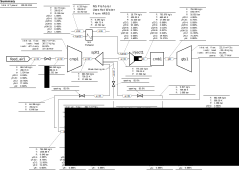



HRSG Section



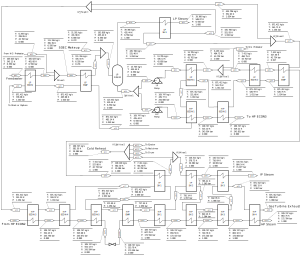



Steam Turbine Section



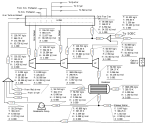



SOEC Section



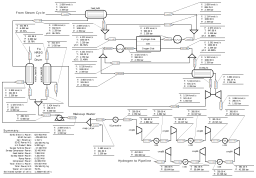

In [12]:
display_pfd()

In [13]:
iutil.from_json(m, fname=save_to, wts=iutil.StoreSpec(suffix=False))

{'etime_load_file': 0.1542372703552246,
 'etime_read_dict': 0.5230402946472168,
 'etime_read_suffixes': 0.0}



Gas Trubine Section



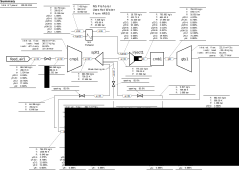



HRSG Section



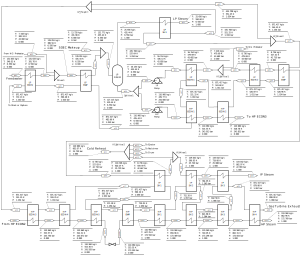



Steam Turbine Section



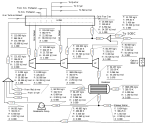



SOEC Section



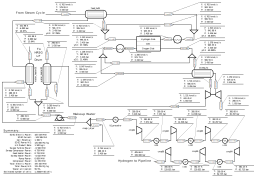

In [14]:
display_pfd()

In [15]:
df.to_csv("data_tabulated/ngcc_soec.csv")

In [16]:
iutil.from_json(m, fname="data/ngcc_soec_480_5000.json.gz", wts=iutil.StoreSpec(suffix=False))

{'etime_load_file': 0.13179516792297363,
 'etime_read_dict': 0.5494561195373535,
 'etime_read_suffixes': 0.0}



Gas Trubine Section



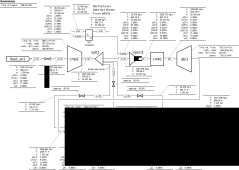



HRSG Section



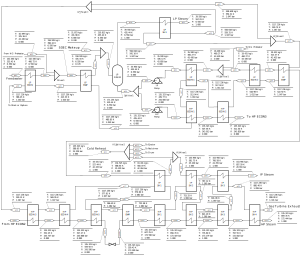



Steam Turbine Section



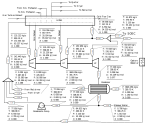



SOEC Section



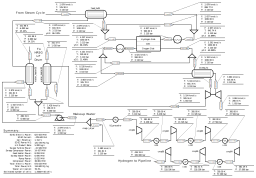

In [17]:
m.fs.ngcc.gt.write_pfd(fname="data_pfds/gt_soec_base.svg")
m.fs.ngcc.hrsg.write_pfd(fname="data_pfds/hrsg_soec_base.svg")
m.fs.ngcc.st.write_pfd(fname="data_pfds/st_soec_base.svg")
m.fs.soec.write_pfd(fname="data_pfds/soec_soec_base.svg")

display_pfd()